This notebook fits a random forest model using all the training data, inspects feature importance and evaluate model performance using five-fold cross validation. The trained model is saved and will be used to predict land cover of Rwanda using the filtered training data.

In [4]:
%matplotlib inline
import os
import datacube
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score,cohen_kappa_score,confusion_matrix,ConfusionMatrixDisplay,balanced_accuracy_score
from sklearn.metrics import roc_curve, auc,balanced_accuracy_score, f1_score, precision_score, recall_score
from joblib import dump

# file paths and attributes
dict_map={1:'Forest',5:'Grassland',7:'Shrubland',9:'Perennial Cropland',10:'Annual Cropland',11:'Wetland',12:'Water Body',13:'Urban Settlement'} # dictionary of class name corresponding to each class value
training_data='Results/manual_random_training_points_scheme_ii_2021_filtered.txt' # filtered training data
# training_data='Results/stratified_random_training_points_scheme_ii_2021_filtered_edited_with_MADs.txt'
# training_data='Results/stratified_random_training_points_scheme_ii_2021_filtered_edited.txt' 
class_name = 'LC_Class_I' # class label in integer format

# define features used for training and prediction
measurements = ['blue','green','red','red_edge_1','red_edge_2', 'red_edge_3','nir_1','nir_2','swir_1','swir_2','NDVI']
# measurements_MAD=['smad','emad','bcmad']
column_names=[class_name]
for measurement in measurements:
    for i in range(6):
        column_names.append(measurement+'_'+str(i))
# for measurement in measurements_MAD:
#     for i in range(2):
#         column_names.append(measurement+'_'+str(i))

# load training data as dataframe
df_training_data= pd.read_csv(training_data,delimiter=' ') # read as pandas dataframe
df_training_data=df_training_data[column_names] # keep only useful attributes
print('training data \n',df_training_data)

# remove NaNs which were somehow export as zeros during extraction of training data
df_training_data=df_training_data.loc[(df_training_data!=0).all(axis=1)].reset_index(drop=True)
print('training data after removing nans\n',df_training_data)

# convert to numpy array
model_input=df_training_data.to_numpy()
print('dimension of loaded training data: ',model_input.shape)

# # grid search to find optimal random forest classifier hyperparameters
# cv=model_selection.StratifiedShuffleSplit(n_splits=5,random_state=1) # stratified shuffle K-fold splitting
# rf = RandomForestClassifier()
# grid_parameters={'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 300, num = 10)],
#                  'min_samples_split':[2,4],'max_features': ['sqrt', 'log2'], 'criterion':['gini', 'entropy', 'log_loss'],
#                 'class_weight':['balanced', None]}
# print('Grid searching best hyper-parameters...')
# grid_search=model_selection.GridSearchCV(estimator = rf,param_grid=grid_parameters,cv=cv,n_jobs=ncpus,scoring='f1_micro')
# grid_search.fit(model_input[:,1:],model_input[:,0])
# print('Optimal parameters: \n',grid_search.best_params_)
# rf = RandomForestClassifier(**grid_search.best_params_, random_state=1, n_jobs=ncpus)

# fit a random classifier using pre-defined hyperparameters
rf=RandomForestClassifier(n_estimators=100,max_samples=None,min_samples_leaf=1,bootstrap=True)
rf.fit(model_input[:,1:],model_input[:,0])

# determine most important features
feat_importance_indices=np.argsort(rf.feature_importances_)[-30:]
print('most importance features: \n',df_training_data.columns[1:][feat_importance_indices])

# # alternatively fit model using selected features
# rf=RandomForestClassifier(n_estimators=100,max_samples=None,min_samples_leaf=1,bootstrap=True)
# rf.fit(model_input[:,1:][:,feat_importance_indices],model_input[:,0])

# save the model
dump(rf, 'Results/RF_model_Rwanda_2021_using_2015_scheme2_manual_random_samples.joblib')
# dump(rf, 'Results/RF_model_Rwanda_2021_using_2015_scheme2_stratified_samples.joblib')

ncpus = 62
training data 
       LC_Class_I       blue_0       blue_1      blue_2       blue_3  \
0           10.0   599.919861   478.500000  540.073914  1034.329712   
1           10.0   299.000031   361.000000  408.895477   645.079773   
2           10.0   523.099976   545.247253  507.158905   585.761780   
3           10.0   846.500000   604.549255  529.981506   653.058899   
4           10.0   290.000092   458.500000  668.662842   776.215088   
...          ...          ...          ...         ...          ...   
3954         9.0   338.377869   595.000000  361.556305   398.339752   
3955         9.0  1160.242798  1355.000000  403.555176   453.980957   
3956         9.0   698.687256   505.866364  493.066467   545.743286   
3957         9.0   624.493347   786.903870  507.199585   873.621582   
3958         9.0   734.499146   777.375488  368.417999   465.018402   

           blue_4      blue_5      green_0      green_1     green_2  ...  \
0     1047.522705  264.000000   833.563599  

RandomForestClassifier()

In [ ]:
# plot and print feature importance
order=np.argsort(rf.feature_importances_)
plt.figure(figsize=(5,30))
plt.barh(y=np.array(df_training_data.columns[1:])[order],width=rf.feature_importances_[order])
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Variable', labelpad=10)
feat_importance_indices=np.argsort(rf.feature_importances_)[-20:]
print('most importance features: \n',df_training_data.columns[1:][feat_importance_indices])

Text(0.5, 0, 'Land cover class')

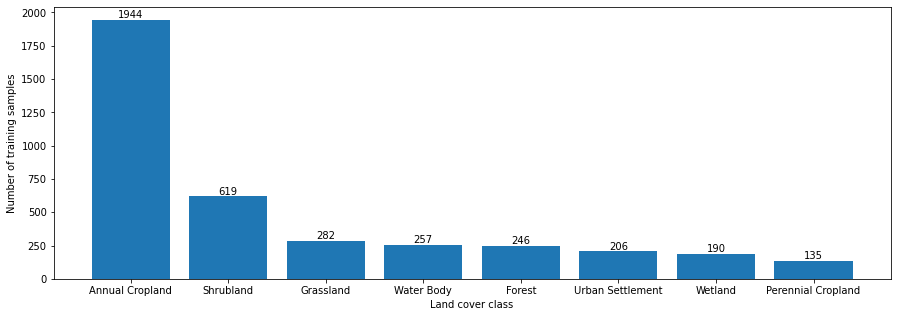

In [2]:
# plot the distribution of training samples by class
class_counts=df_training_data[class_name].value_counts()
class_indices=class_counts.index
class_legends=[dict_map[class_indices[i]] for i in range(len(class_indices))]
plt.figure(figsize=(15,5))
ax=plt.bar(class_legends,height=class_counts.to_numpy())
plt.bar_label(ax)
plt.gca().set_ylabel('Number of training samples')
plt.gca().set_xlabel('Land cover class')

Overall accuracy from cv scores:  0.721575656800798
f1_macro from cv scores:  0.6209313680443527
Overall accuracy from cv:  0.7226062520784835
Overall accuracy from cv predict:  0.719773137406548
Balanced accuracy from cv predict:  0.5690115705039597
Precision for each class: 
 {'Forest': 0.751, 'Grassland': 0.617, 'Shrubland': 0.631, 'Perennial Cropland': 0.659, 'Annual Cropland': 0.704, 'Wetland': 0.815, 'Water Body': 0.985, 'Urban Settlement': 0.708}
Recall for each class: 
 {'Forest': 0.724, 'Grassland': 0.177, 'Shrubland': 0.414, 'Perennial Cropland': 0.215, 'Annual Cropland': 0.93, 'Wetland': 0.626, 'Water Body': 0.996, 'Urban Settlement': 0.471}
f1 score for each class: 
 {'Forest': 0.737, 'Grassland': 0.275, 'Shrubland': 0.5, 'Perennial Cropland': 0.324, 'Annual Cropland': 0.801, 'Wetland': 0.708, 'Water Body': 0.99, 'Urban Settlement': 0.566}
Confusion matrix:



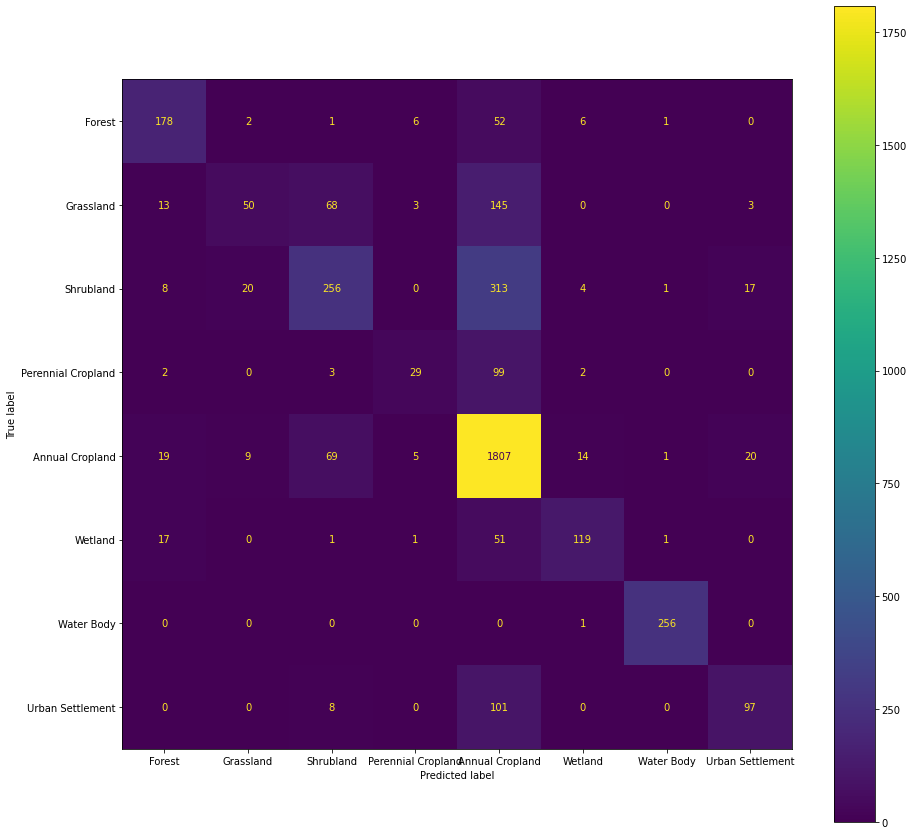

In [5]:
# evaluate model through cross validation
skf=model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=1) # stratified K-fold splitting
overall_acc=model_selection.cross_val_score(rf,model_input[:,1:],model_input[:,0],cv=skf,scoring='accuracy')
print('Overall accuracy from cv scores: ',np.mean(overall_acc))
# print('Overall accuracy: ',np.mean(overall_acc)*100,'%')

f1_macro=model_selection.cross_val_score(rf,model_input[:,1:],model_input[:,0],cv=skf,scoring='f1_macro')
print('f1_macro from cv scores: ',np.mean(f1_macro))

cv_results=model_selection.cross_validate(rf,model_input[:,1:],model_input[:,0],cv=skf)
print('Overall accuracy from cv: ',np.mean(cv_results['test_score']))

predictions=model_selection.cross_val_predict(rf,model_input[:,1:],model_input[:,0],cv=skf)
print('Overall accuracy from cv predict: ',accuracy_score(model_input[:, 0],predictions))
print('Balanced accuracy from cv predict: ',balanced_accuracy_score(model_input[:, 0],predictions))

values=list(dict_map.keys())
precision=precision_score(model_input[:,0],predictions,labels=values,average=None)
print('Precision for each class: \n',dict(zip([dict_map[value] for value in values],np.around(precision,3))))

recall=recall_score(model_input[:,0],predictions,labels=values,average=None)
print('Recall for each class: \n',dict(zip([dict_map[value] for value in values],np.around(recall,3))))

f1_scores=f1_score(model_input[:,0],predictions,labels=values,average=None)
print('f1 score for each class: \n',dict(zip([dict_map[value] for value in values],np.around(f1_scores,3))))

cm=confusion_matrix(model_input[:, 0], predictions)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[dict_map[rf.classes_[i]] for i in range(len(rf.classes_))])
print('Confusion matrix:\n')
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)